In [22]:
%matplotlib widget

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [39]:
ckpt_dir = "/home/ccl/Code/svox2/opt/ckpt_auto/scannerf_light_short"
plot_dir = "/home/ccl/Downloads/plots"


def load_results(results_dir):
    c2ws = np.load(os.path.join(results_dir, "c2ws.npy"))
    psnr = np.load(os.path.join(results_dir, "psnr.npy"))
    ssim = np.load(os.path.join(results_dir, "ssim.npy"))
    lpips = np.load(os.path.join(results_dir, "lpips.npy"))
    return c2ws, psnr, ssim, lpips
    
suffixes = ["all_100", "all"]
# suffixes = ["all_100", "all_250", "all_500", "all"]
scenes = ["airplane1", "brontosaurus", "lego"]
# scenes = ["airplane1", "airplane2", "brontosaurus", "bulldozer1", "bulldozer2", "cheetah", "dump_truck1", "dump_truck2", "elephant", "excavator", "forklift", "giraffe", "helicopter1", "helicopter2", "lego", "lion", "plant1", "plant2", "plant3", "plant4", "plant5", "plant6", "plant7", "plant8", "plant9", "roadroller", "shark", "spinosaurus", "stegosaurus", "tiger", "tractor", "trex", "triceratops", "truck", "zebra"]
c2ws_test = {}
c2ws_train = {}
psnr_test = {}
psnr_train = {}


for suffix in suffixes:
    c2ws_test[suffix] = {}
    c2ws_train[suffix] = {}
    psnr_test[suffix] = {}
    psnr_train[suffix] = {}
    for scene in scenes:
        test_results_dir = os.path.join(ckpt_dir, suffix, scene, "test_renders")
        train_results_dir = os.path.join(ckpt_dir, suffix, scene, "train_renders")

        c2ws_test_i, psnr_test_i, ssim_test_i, lpips_test_i = load_results(test_results_dir)
        c2ws_train_i, psnr_train_i, ssim_train_i, lpips_train_i = load_results(train_results_dir)
        
        # cos_dist = np.matmul(directions, directions_train.transpose())
        # closest_train_index = np.argmax(cos_dist, axis=1)
        # cos_dist = np.max(cos_dist, axis=1)
        # rel_angles = np.arccos(cos_dist)

        c2ws_test[suffix][scene] = c2ws_test_i
        c2ws_train[suffix][scene] = c2ws_train_i
        psnr_test[suffix][scene] = psnr_test_i
        psnr_train[suffix][scene] = psnr_train_i

c2ws = next(iter(next(iter(c2ws_test.values())).values()))
center_pt = np.zeros(3)
directions = (c2ws[:,:3,3] - center_pt)
directions = directions / np.linalg.norm(directions, keepdims=True, axis=1)

angles_equator = np.arctan2(directions[:,0], directions[:,2])
angles_vert_x = np.arctan2(-directions[:,1], directions[:,0])
angles_vert_z = np.arctan2(-directions[:,1], directions[:,2])

# best_psnr = np.max(psnrs, axis=0)
# best_psnr_idx = np.argmax(psnrs, axis=0)

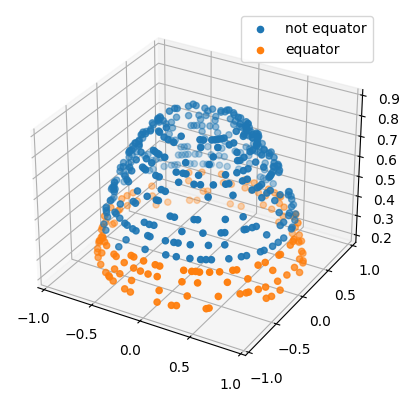

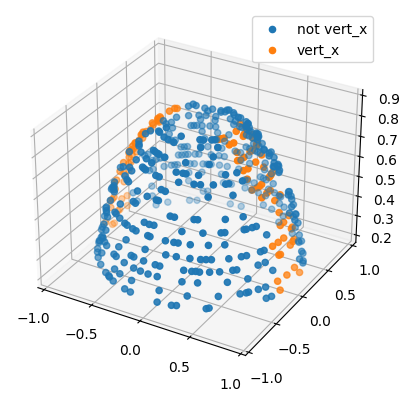

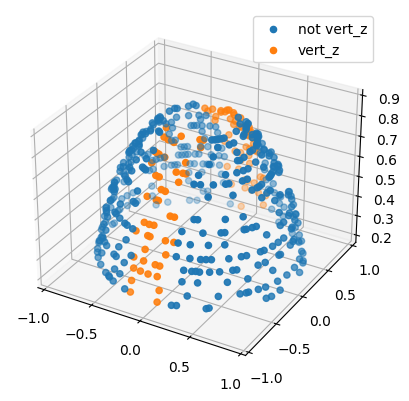

In [84]:
def xyz(c2ws):
    return c2ws[:,0,3], c2ws[:,2,3], -c2ws[:,1,3]

def plot_filter(condition, labels, filename, angles):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    inlier = np.where(condition)
    outlier = np.where(np.logical_not(condition))
    ax.scatter(*xyz(c2ws[outlier]), label=labels[1])
    ax.scatter(*xyz(c2ws[inlier]), label=labels[0])
    ax.legend()
    fig.savefig(os.path.join(plot_dir, filename))
    
    return inlier[0]

equator = plot_filter(c2ws[:,1,3] > -0.4, ["equator", "not equator"], "equator_selection.jpeg", angles_equator)
vert_x = plot_filter(np.abs(c2ws[:,2,3]) < 0.2, ["vert_x", "not vert_x"], "vert_x_selection.jpeg", angles_vert_x)
vert_z = plot_filter(np.abs(c2ws[:,0,3]) < 0.2, ["vert_z", "not vert_z"], "vert_z_selection.jpeg", angles_vert_z)


In [85]:
%matplotlib inline

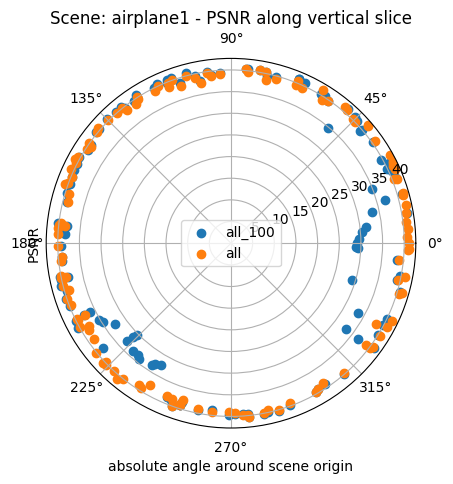

In [86]:
scene = "airplane1"


def plot_quality(scene, theta, quality, img_ids, filename):
    fig = plt.figure()
    ax = fig.add_subplot(projection='polar')
    plt.ylabel("PSNR")
    plt.xlabel("absolute angle around scene origin")
    plt.title(f"Scene: {scene} - PSNR along vertical slice")
    for suffix in suffixes:
        r = quality[suffix][scene]
        ax.scatter(theta[img_ids], r[img_ids], label=f"{suffix}")

    ax.legend()
    fig.savefig(os.path.join(plot_dir, filename))
    return fig

fig = plot_quality(scene, angles_equator, psnr_test, equator, f"{scene}_psnr_equator.jpeg")
# plt.close(fig)
# fig = plot_quality(scene, angles_vert_x, psnr_test, vert_x, f"{scene}_psnr_vert_x.jpeg")
# plt.close(fig)
# fig = plot_quality(scene, angles_vert_z, psnr_test, vert_z, f"{scene}_psnr_vert_z.jpeg")
# plt.close(fig)



In [111]:
sample_num = 2
fail_idx = np.argsort(psnr_test["all_100"][scene][vert_z])[:sample_num]
success_idx = np.argsort(psnr_test["all_100"][scene][vert_z])[-sample_num:][::-1]

In [117]:
def vis_sample(img_id, desc, img_ids, ):
    fig = plt.figure(figsize=(10,8))
    ax1 = plt.subplot(211, projection='polar')
    ax2 = plt.subplot(212)
    theta = angles_vert_z[img_ids]
    
    ax1.title.set_text(f"{desc} - img_id {img_id}")
    for j, suffix in enumerate(suffixes):
        r = psnr_test[suffix][scene]
        ax1.scatter(theta, r[img_ids], s=5, label=suffix)
    psnr = psnr_test["all_100"][scene][img_id]
    ax1.scatter(angles_vert_z[img_id], psnr, s=100, label=f"current")
    
    
    img_path = os.path.join(ckpt_dir, "all_100", scene, "test_renders", f'{img_id:04d}.png')
    img = np.asarray(Image.open(img_path))
    ax2.title.set_text(f"{desc} - PSNR: {psnr:.2f}")
    ax2.imshow(img)
    
    fig.savefig(os.path.join(plot_dir, f"{scene}_{desc}_{psnr:.01f}_{img_id}.png"))
    
# vis_sample(vert_z[0], "failure_case", vert_z)

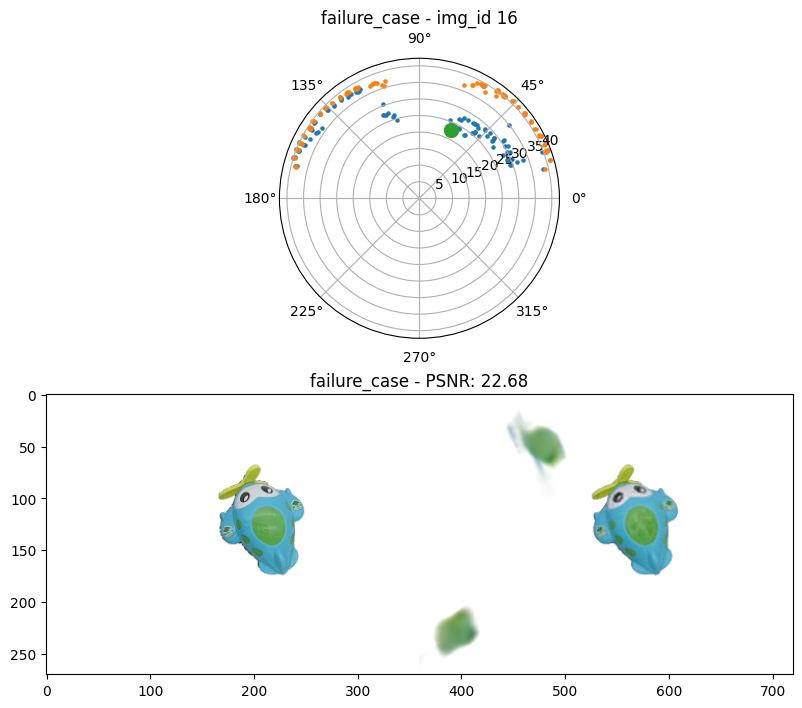

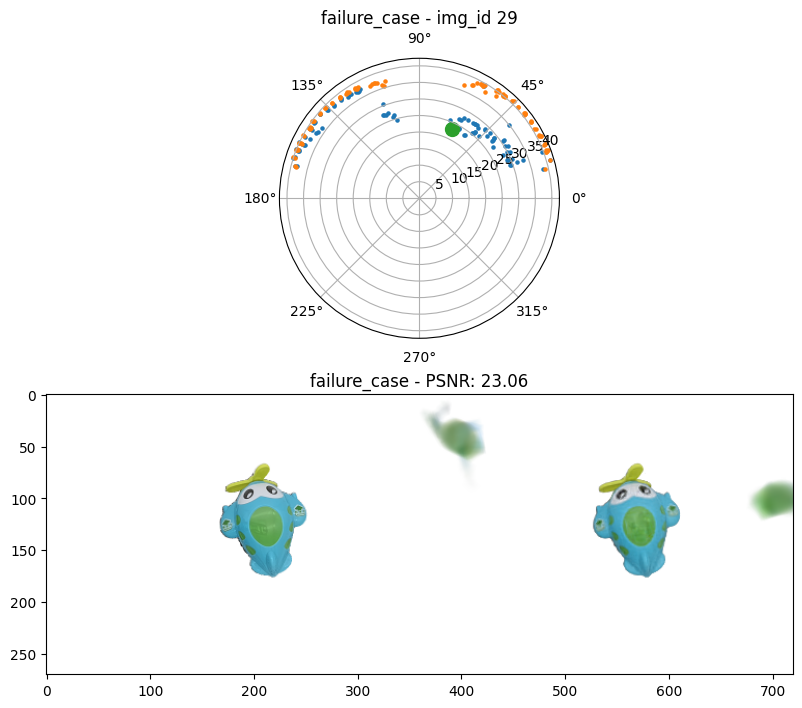

In [118]:

for img_id in list(vert_z[fail_idx]):
    vis_sample(img_id, "failure_case", vert_z)

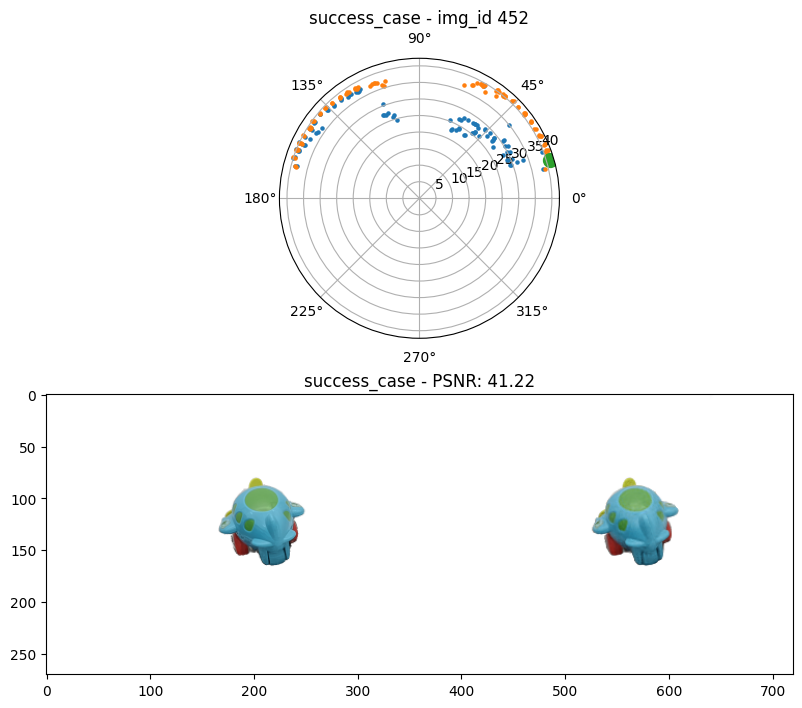

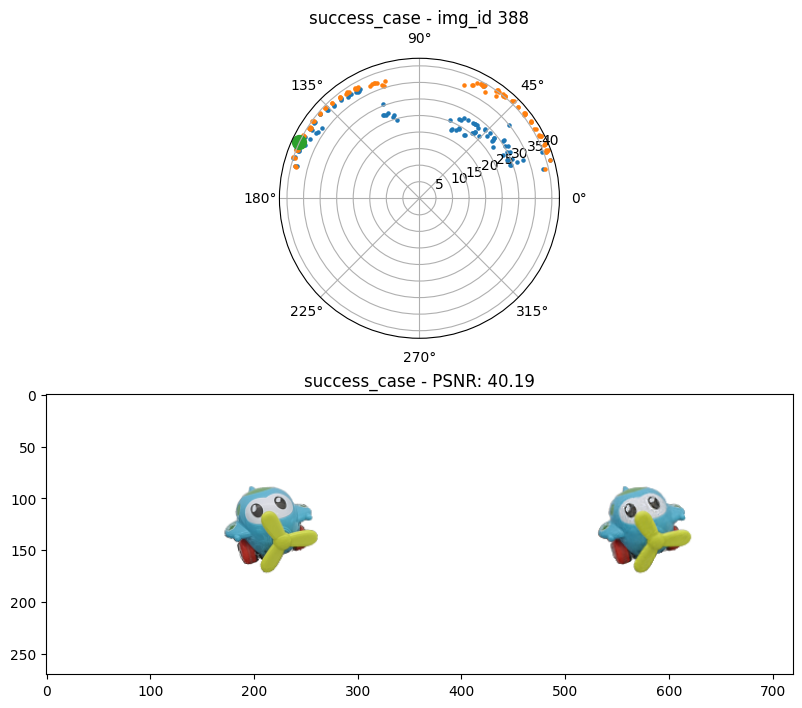

In [119]:
for img_id in list(vert_z[success_idx]):
    vis_sample(img_id, "success_case", vert_z)
    

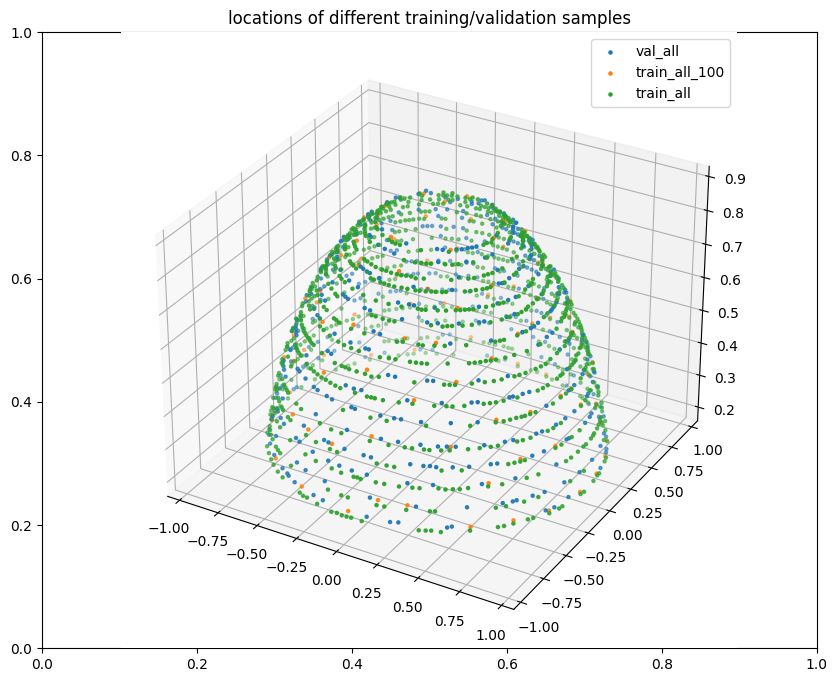

In [123]:

fig = plt.figure(figsize=(10,8))
plt.title("locations of different training/validation samples")
ax = fig.add_subplot(projection='3d')

ax.scatter(*xyz(c2ws), s=5, label="val_all")
for suffix in suffixes:
    # plt.title(f"train locations {suffix}")
    ax.scatter(*xyz(c2ws_train[suffix][scene]), s=5, label=f"train_{suffix}")

ax.legend()
fig.savefig(f"/home/ccl/Downloads/plots/{scene}_sample_locations.jpeg")